In [ ]:
import pandas as pd

df = pd.read_csv('/content/data.csv', encoding='ISO-8859-1')
df.columns = df.columns.str.strip()  # clean column names
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # convert date
df.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
# Total Price for each row (Quantity × UnitPrice)
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Extract Month and Date for time-based analysis
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')
df['InvoiceDateOnly'] = df['InvoiceDate'].dt.date


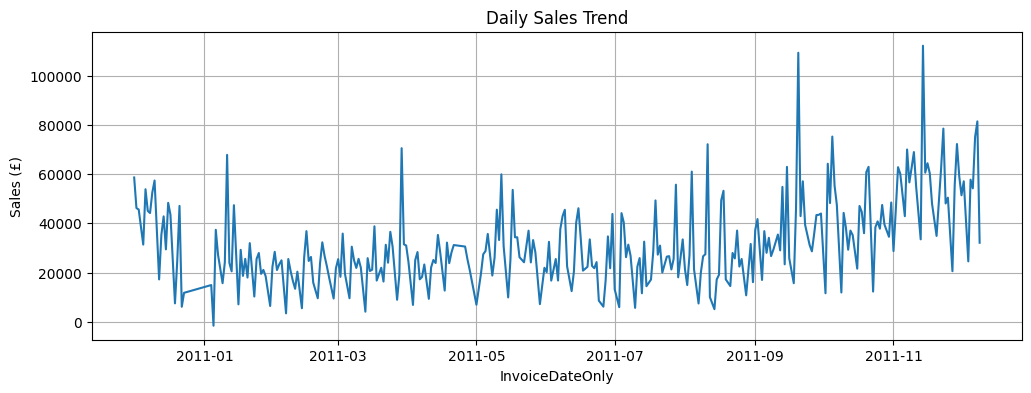

In [ ]:
import matplotlib.pyplot as plt

daily_sales = df.groupby('InvoiceDateOnly')['TotalPrice'].sum()
daily_sales.plot(kind='line', figsize=(12, 4), title='Daily Sales Trend')
plt.ylabel('Sales (£)')
plt.grid()
plt.show()


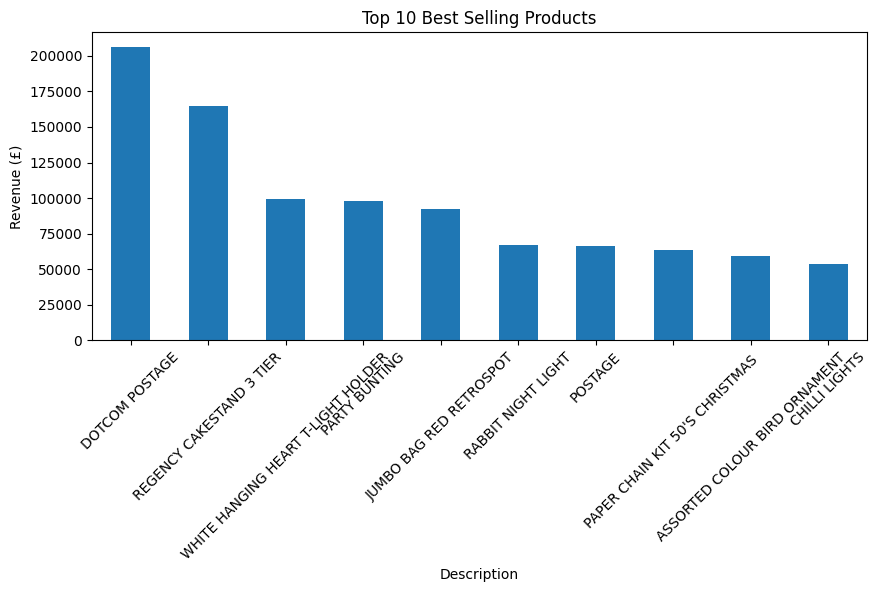

In [ ]:
top_products = df.groupby('Description')['TotalPrice'].sum().nlargest(10)
top_products.plot(kind='bar', figsize=(10, 4), title='Top 10 Best Selling Products')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
plt.show()


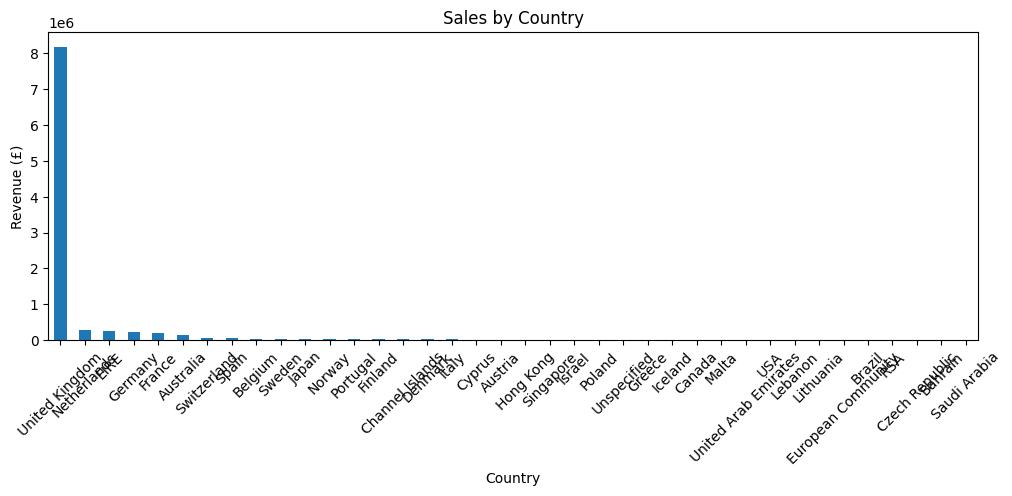

In [ ]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)
country_sales.plot(kind='bar', figsize=(12, 4), title='Sales by Country')
plt.ylabel('Revenue (£)')
plt.xticks(rotation=45)
plt.show()


In [ ]:
unique_customers = df['CustomerID'].nunique()
print(f"Total Unique Customers: {unique_customers}")


Total Unique Customers: 4372


In [ ]:
# Remove returns (invoices starting with 'C')
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

# Drop rows without customer ID
df = df.dropna(subset=['CustomerID'])


In [ ]:
ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)


In [ ]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,   # Recency
    'InvoiceNo': 'nunique',                               # Frequency
    'TotalPrice': 'sum'                                   # Monetary
})

rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
rfm.head()


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12347.0,2,7,4310.00
2,12348.0,75,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,310,1,334.40


In [ ]:
# Higher frequency & monetary = better; lower recency = better
rfm['R_Score'] = pd.qcut(rfm['Recency'], 4, labels=[4, 3, 2, 1])
rfm['F_Score'] = pd.qcut(rfm['Frequency'].rank(method='first'), 4, labels=[1, 2, 3, 4])
rfm['M_Score'] = pd.qcut(rfm['Monetary'], 4, labels=[1, 2, 3, 4])

# Combine into single RFM Score
rfm['RFM_Segment'] = rfm['R_Score'].astype(str) + rfm['F_Score'].astype(str) + rfm['M_Score'].astype(str)
rfm['RFM_Score'] = rfm[['R_Score', 'F_Score', 'M_Score']].astype(int).sum(axis=1)

rfm.head()


,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,RFM_Segment,RFM_Score
0,12346.0,326,1,77183.60,1,1,4,114,6
1,12347.0,2,7,4310.00,4,4,4,444,12
2,12348.0,75,4,1797.24,2,3,4,234,9
3,12349.0,19,1,1757.55,3,1,4,314,8
4,12350.0,310,1,334.40,1,1,2,112,4


In [ ]:
def segment_customer(score):
    if score >= 9:
        return 'Champions'
    elif score >= 7:
        return 'Loyal Customers'
    elif score >= 5:
        return 'Potential Loyalist'
    else:
        return 'At Risk'

rfm['Segment'] = rfm['RFM_Score'].apply(segment_customer)
rfm['Segment'].value_counts()


,count
Segment,
Champions,1680
Potential Loyalist,989
Loyal Customers,863
At Risk,807


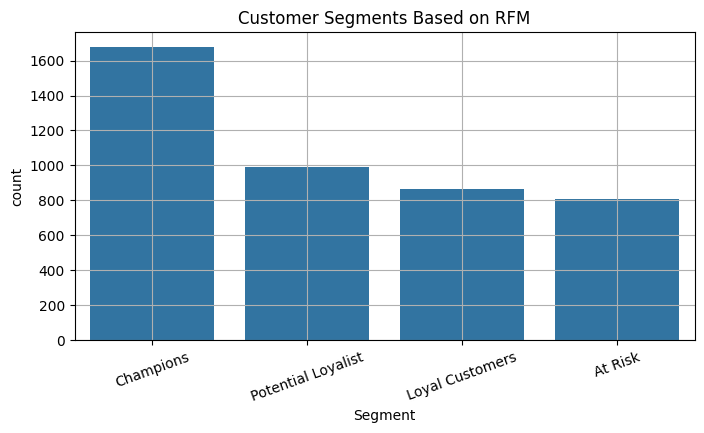

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.countplot(data=rfm, x='Segment', order=rfm['Segment'].value_counts().index)
plt.title('Customer Segments Based on RFM')
plt.xticks(rotation=20)
plt.grid()
plt.show()


In [ ]:
!pip install mlxtend --quiet


In [ ]:
import pandas as pd

# Filter data for a single country to reduce noise (e.g., UK)
basket_df = df[df['Country'] == 'United Kingdom']

# Group by InvoiceNo and Description, summing Quantity
basket = basket_df.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)

# Convert quantities to 1 (purchased) or 0 (not purchased)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket.head()


/tmp/ipython-input-14-2100341629.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,TOADSTOOL BEDSIDE LIGHT,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
basket_df_small = df[
    (df['Country'] == 'United Kingdom') &
    (df['InvoiceDate'].dt.month == 12) &
    (df['InvoiceDate'].dt.year == 2010)
]

basket_small = basket_df_small.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
basket_small = basket_small.applymap(lambda x: 1 if x > 0 else 0)


/tmp/ipython-input-16-562633896.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_small = basket_small.applymap(lambda x: 1 if x > 0 else 0)


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

frequent_itemsets = apriori(basket_small, min_support=0.02, use_colnames=True)
frequent_itemsets.sort_values(by='support', ascending=False).head()


/usr/local/lib/python3.11/dist-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,support,itemsets
196,0.151820,(WHITE HANGING HEART T-LIGHT HOLDER)
68,0.102246,(HAND WARMER BABUSHKA DESIGN)
119,0.100697,(PAPER CHAIN KIT 50'S CHRISTMAS )
165,0.099148,(SCOTTIE DOG HOT WATER BOTTLE)
153,0.093726,(REGENCY CAKESTAND 3 TIER)


In [ ]:
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules = rules.sort_values(by='confidence', ascending=False)
rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head(10)


,antecedents,consequents,support,confidence,lift
156,"(WOODEN FRAME ANTIQUE WHITE , WOOD 2 DRAWER CA...",(WOODEN PICTURE FRAME WHITE FINISH),0.020914,0.900000,17.341791
139,"(POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...",(POPPY'S PLAYHOUSE KITCHEN),0.022463,0.878788,24.663373
138,"(POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHO...",(POPPY'S PLAYHOUSE BEDROOM ),0.022463,0.878788,24.663373
151,"(WOOD S/3 CABINET ANT WHITE FINISH, WOODEN PIC...",(WOOD 2 DRAWER CABINET WHITE FINISH),0.020139,0.866667,17.213333
6,(CANDLEHOLDER PINK HANGING HEART),(WHITE HANGING HEART T-LIGHT HOLDER),0.022463,0.852941,5.618097
1,(ALARM CLOCK BAKELIKE ORANGE),(ALARM CLOCK BAKELIKE GREEN),0.024012,0.837838,15.906598
158,"(WOOD 2 DRAWER CABINET WHITE FINISH, WOODEN PI...",(WOODEN FRAME ANTIQUE WHITE ),0.020914,0.818182,13.370541
88,(LARGE POPCORN HOLDER ),(SMALL POPCORN HOLDER),0.022463,0.805556,15.072061
140,"(POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE ...",(POPPY'S PLAYHOUSE LIVINGROOM ),0.022463,0.805556,25.365176
96,(POPPY'S PLAYHOUSE LIVINGROOM ),(POPPY'S PLAYHOUSE BEDROOM ),0.025562,0.804878,22.589077


In [ ]:
# Convert frozensets to strings for readability
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))
rules.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
156,"WOODEN FRAME ANTIQUE WHITE , WOOD 2 DRAWER CAB...",WOODEN PICTURE FRAME WHITE FINISH,0.023238,0.051898,0.020914,0.900000,17.341791,1.0,0.019708,9.481022,0.964755,0.385714,0.894526,0.651493
139,"POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOU...",POPPY'S PLAYHOUSE KITCHEN,0.025562,0.035631,0.022463,0.878788,24.663373,1.0,0.021552,7.956042,0.984623,0.580000,0.874309,0.754611
138,"POPPY'S PLAYHOUSE LIVINGROOM , POPPY'S PLAYHOU...",POPPY'S PLAYHOUSE BEDROOM,0.025562,0.035631,0.022463,0.878788,24.663373,1.0,0.021552,7.956042,0.984623,0.580000,0.874309,0.754611
151,"WOOD S/3 CABINET ANT WHITE FINISH, WOODEN PICT...",WOOD 2 DRAWER CABINET WHITE FINISH,0.023238,0.050349,0.020139,0.866667,17.213333,1.0,0.018969,7.122386,0.964314,0.376812,0.859598,0.633333
6,CANDLEHOLDER PINK HANGING HEART,WHITE HANGING HEART T-LIGHT HOLDER,0.026336,0.151820,0.022463,0.852941,5.618097,1.0,0.018465,5.767622,0.844238,0.144279,0.826618,0.500450
1,ALARM CLOCK BAKELIKE ORANGE,ALARM CLOCK BAKELIKE GREEN,0.028660,0.052672,0.024012,0.837838,15.906598,1.0,0.022503,5.841854,0.964784,0.418919,0.828821,0.646860
158,"WOOD 2 DRAWER CABINET WHITE FINISH, WOODEN PIC...",WOODEN FRAME ANTIQUE WHITE,0.025562,0.061193,0.020914,0.818182,13.370541,1.0,0.019350,5.163439,0.949479,0.317647,0.806331,0.579977
88,LARGE POPCORN HOLDER,SMALL POPCORN HOLDER,0.027885,0.053447,0.022463,0.805556,15.072061,1.0,0.020973,4.867987,0.960434,0.381579,0.794576,0.612923
140,"POPPY'S PLAYHOUSE KITCHEN, POPPY'S PLAYHOUSE B...",POPPY'S PLAYHOUSE LIVINGROOM,0.027885,0.031758,0.022463,0.805556,25.365176,1.0,0.021578,4.979529,0.988130,0.604167,0.799178,0.756436
96,POPPY'S PLAYHOUSE LIVINGROOM,POPPY'S PLAYHOUSE BEDROOM,0.031758,0.035631,0.025562,0.804878,22.589077,1.0,0.024430,4.942390,0.987079,0.611111,0.797669,0.761135


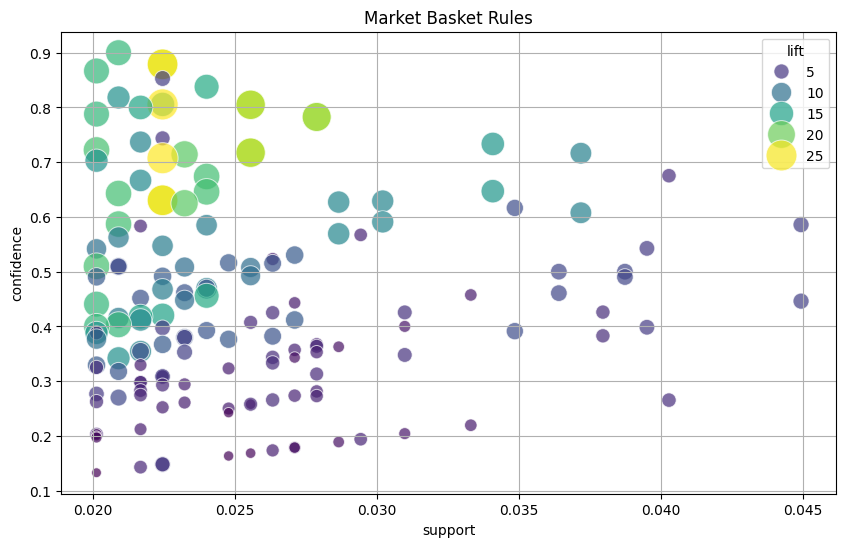

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(data=rules, x='support', y='confidence', size='lift', hue='lift', palette='viridis', alpha=0.7, sizes=(50, 500))
plt.title('Market Basket Rules')
plt.grid()
plt.show()


In [ ]:
import pandas as pd

# Ensure InvoiceDate is datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Group by date (daily total sales)
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
daily_sales.columns = ['ds', 'y']  # Prophet expects these column names
daily_sales.head()


,ds,y
0,2010-12-01,46376.49
1,2010-12-02,47316.53
2,2010-12-03,23921.71
3,2010-12-05,31771.60
4,2010-12-06,31215.64


In [ ]:
from prophet import Prophet

model = Prophet(daily_seasonality=True)
model.fit(daily_sales)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2fvmd30/aruoqfis.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw2fvmd30/aaiscoly.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48974', 'data', 'file=/tmp/tmpw2fvmd30/aruoqfis.json', 'init=/tmp/tmpw2fvmd30/aaiscoly.json', 'output', 'file=/tmp/tmpw2fvmd30/prophet_modelpvxujavs/prophet_model-20250714194702.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
19:47:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
19:47:02 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Forecast for next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


,ds,yhat,yhat_lower,yhat_upper
330,2012-01-04,56999.349941,38285.385628,75635.329060
331,2012-01-05,64447.913351,46492.321676,82399.012451
332,2012-01-06,56652.411799,39191.029343,76096.193455
333,2012-01-07,59128.378366,41642.771992,76591.465617
334,2012-01-08,43568.862630,25845.666913,60092.465729


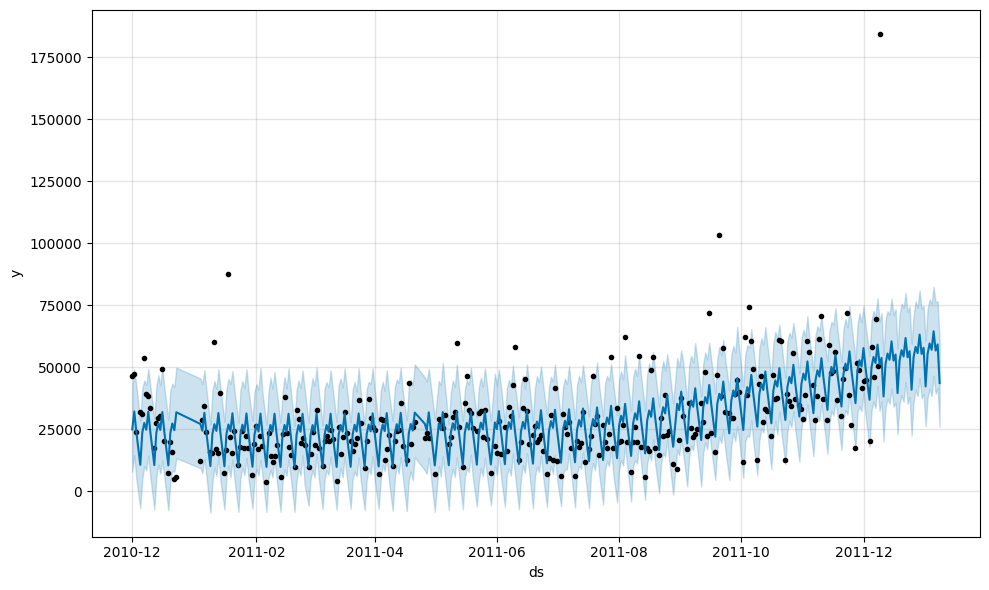

In [ ]:
fig1 = model.plot(forecast)
fig1.show()


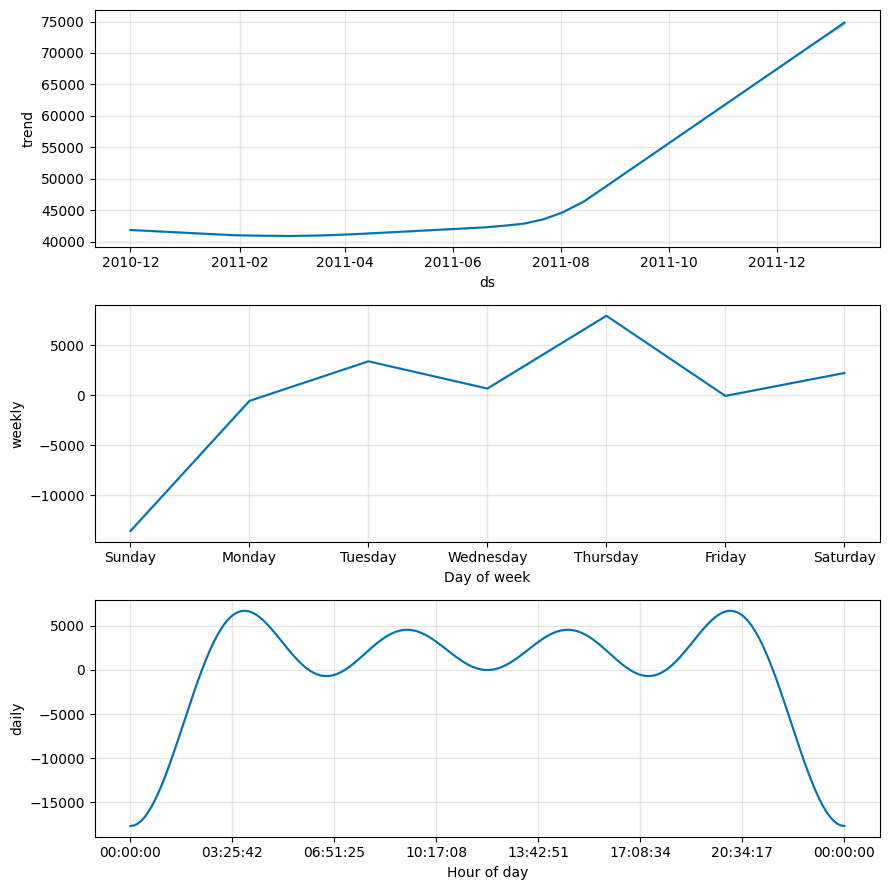

In [ ]:
fig2 = model.plot_components(forecast)
fig2.show()
